In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import pimf

# Rejection Sampling
A simple form of rejection sampling is drawing points $(x, y)$ randomly in a box around our function, and keeping $x$ only when $y < p(x)$.

This can be made more sophisticated by using another function instead of a simple box, but there is an even better method for our case we will use anyway.

In [2]:
def rejection_sample(p, xmin, xmax, ymin, ymax, N):
    x = rng.uniform(xmin, xmax, size=int(120*ymax*N))
    y = rng.uniform(ymin, ymax, size=int(120*ymax*N))
    accepted = x[y < p(x)]
    if len(accepted) >= N:
        return accepted[:N]
    raise RuntimeError(f"fart noise: {len(accepted) = }")

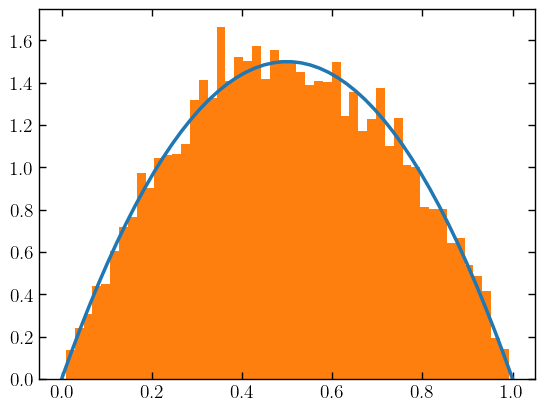

In [3]:
x = np.linspace(0, 1)

def p(x):
    return 6*(x - x*x)

plt.plot(x, p(x))
plt.hist(rejection_sample(p, 0, 1, 0, 1.6, 10_000), density=True, bins=50)
plt.show()

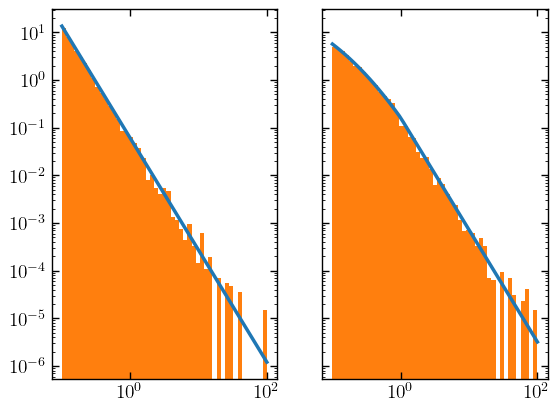

In [4]:
M = np.geomspace(0.1, 100)
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

imf = pimf.PowerLawIMF(normalisation="number")
axes[0].loglog(M, imf(M))
axes[0].hist(rejection_sample(imf, 0.1, 100, 0, imf(M[0]), 5000), density=True, bins=M)

imf = pimf.ChabrierIMF(normalisation="number")
axes[1].loglog(M, imf(M))
axes[1].hist(rejection_sample(imf, 0.1, 100, 0, imf(M[0]), 5000), density=True, bins=M)

plt.show()

# Inverse CDF
The Cumulative Distribution Function (CDF) is the integral of the pdf. The inverse of this is also called the quantile function.

It has the property that when you draw a uniform random number and put it through the inverse CFD, it will sample the probability distribution function.



In [5]:
def p(x):
    return 2*x

def P(x):
    return x*x

def invP(x):
    return np.sqrt(x)

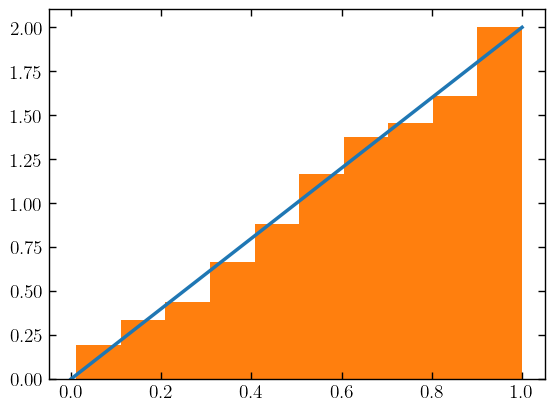

In [6]:
x = np.linspace(0, 1)
plt.plot(x, p(x))
plt.hist(invP(rng.uniform(size=1000)), density=True)
plt.show()

## General Power Laws
$$\begin{align}
p(x) = x^n \\
P(x) = \frac{x^{n+1}}{n+1} \\
P^{-1}(x) = ((n+1) x)^\frac{1}{n+1}
\end{align}
$$

In [7]:
def A(a, b, n):
    return (n+1) / (b**(n+1) - a**(n+1))

def p(x, a=1, b=2, n=-2.35):
    return A(a, b, n) * x ** n

def P(x, a=1, b=2, n=-2.35):
    return A(a, b, n) * (x**(n+1) - a**(n+1)) / (n+1)

def invP(x, a=1, b=2, n=-2.35):
    return ((n+1)/A(a, b, n) * x + a**(n+1)) ** (1 / (n+1))

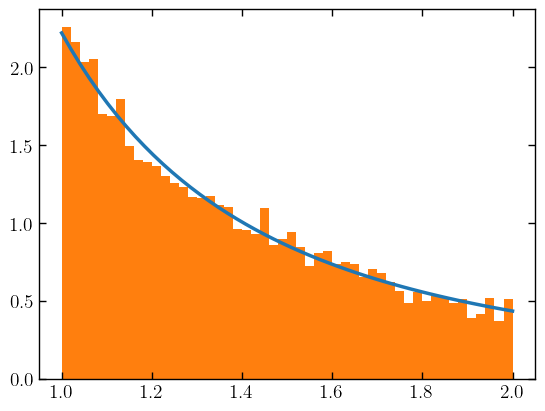

In [8]:
x = np.linspace(1, 2)
plt.plot(x, p(x))
plt.hist(invP(rng.uniform(size=10000)), density=True, bins=50)
plt.show()

## Salpeter
We can add an `inverse_cdf` function that calculates the inverse cdf. There is one distinction as we go from our definition of the IMF to the pdf, we need to change instances of $\xi_0 \rightarrow \xi_0 / N$. Crazy but true. (Maybe not as true as I thought :()

The inverse_cdf function should alwas take a value between 0 and 1, else you're using it wrong.

In [9]:
class NewPowerLawIMF(pimf.PowerLawIMF):
    def inverse_cdf(self, x, Mmin=None):
        if Mmin is None:
            Mmin = self.Mmin
        αp1 = self.α + 1
        N = self.integrate(self.Mmin, self.Mmax)
        return ((αp1 * N / self.ξ0) * x + Mmin**αp1) ** (1 / αp1)

In [10]:
new_salpeter = NewPowerLawIMF(normalisation="number", normalisation_value=10)
new_salpeter.inverse_cdf(0.5)

0.1670923287338747

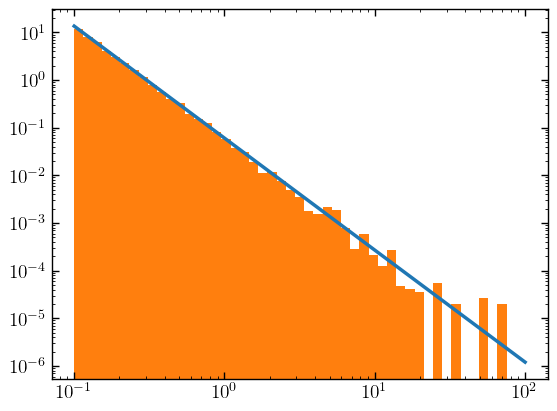

In [11]:
new_salpeter = NewPowerLawIMF(normalisation="number", normalisation_value=1)
M = np.geomspace(0.1, 100)
plt.loglog(M, new_salpeter(M) / new_salpeter.integrate(0.1, 100))  # Make sure we plot the "pdf" style of IMF
plt.hist(new_salpeter.inverse_cdf(rng.uniform(0, 1, 10000), 0.1), density=True, bins=M)
plt.show()

## Kroupa IMF
We start with discussion of piecewise inverses in general.
$$
f(x) = 
\begin{cases}
f_1(x) &x<x_c \\
f_2(x) &x_c < x
\end{cases}
$$

$$
F^{-1}(x; a) = 
\begin{cases}
F^{-1}_1(x; a) &x<x_c \\
F^{-1}_1(x_c; a) + F^{-1}_2(x; a) &x_c < x
\end{cases}
$$

Now, specifically for the Kroupa IMF

In [12]:
class NewBrokenPowerLawIMF(pimf.BrokenPowerLawIMF):
    def inverse_cdf(self, x, Mmin=None):
        if Mmin is None:
            Mmin = self.Mmin
        α1p1 = self.α1 + 1
        α2p1 = self.α2 + 1
        N = self.integrate(self.Mmin, self.Mmax)
        xtransition = self.integrate(Mmin, self.Mtransition) / N  # N to go from our IMF normalisation to a PDF
        # We need to consider two cases:
        # When we are above the transition
        # When we are below the transition
        if isinstance(x, (np.ndarray, tuple, list)):
            x = np.asarray(x)
            out = np.zeros_like(x, dtype=float)
            out[x < xtransition] = ((α1p1 * N / self.ξ0) * x[x < xtransition] + Mmin**α1p1) ** (1 / α1p1)  # Below transition
            out[x >= xtransition] = ((α2p1 * N / (self.ξ0*self.ξcontinuity)) * (x[x >= xtransition] - xtransition) + self.Mtransition**α2p1) ** (1 / α2p1)  # Above transition
            return out
        else:
            if x < xtransition:  # Below transition
                return ((α1p1 * N / self.ξ0) * x + Mmin**α1p1) ** (1 / α1p1)
            else:  # Above transition
                return ((α2p1 * N / (self.ξ0*self.ξcontinuity)) * (x - xtransition) + self.Mtransition**α2p1) ** (1 / α2p1)


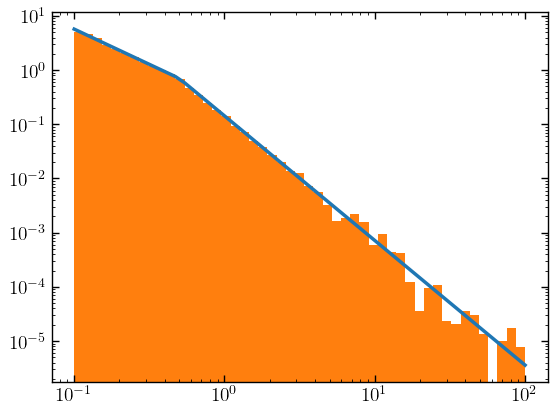

In [13]:
new_kroupa = NewBrokenPowerLawIMF(normalisation="mass", normalisation_value=7000)
M = np.geomspace(0.1, 100)
plt.loglog(M, new_kroupa(M) / new_kroupa.integrate(0.1, 100))
plt.hist(new_kroupa.inverse_cdf(rng.uniform(0, 1, 10000), 0.1), density=True, bins=M)
plt.show()

## Chabrier IMF
This is probably were I'll leave it? Or maybe not, knowing me...


In [14]:
from scipy import special
class NewChabrierIMF(pimf.ChabrierIMF):
    def inverse_cdf(self, x, Mmin=None):
        #### This implementation is really messy but I was having so much trouble getting it to work. I don't think I did anything different, and it suddenly was fine...
        if Mmin is None:
            Mmin = self.Mmin
        αp1 = self.α + 1
        Mtransition = 1
        N = self.integrate(self.Mmin, self.Mmax)
        xtransition = self.integrate(Mmin, Mtransition) / N  # N to go from our IMF normalisation to a PDF
        μ1 = np.log10(Mmin / self.mc) / (np.sqrt(2)*self.σ)
        # We need to consider two cases:
        # When we are above the transition
        # When we are below the transition
        if isinstance(x, (np.ndarray, tuple, list)):
            x = np.asarray(x)
            out = np.zeros_like(x, dtype=float)
            out[x < xtransition] = self.mc * 10 ** ( (np.sqrt(2)*self.σ) * special.erfinv(N*x[x<xtransition]/(self.ξ0 * self.lognormal_integral_constant) + special.erf(μ1) )  )  # Below transition
            out[x >= xtransition] = ((αp1 * N / (self.ξ0*self.ξcontinuity)) * (x[x >= xtransition] - xtransition) + Mtransition**αp1) ** (1 / αp1)  # Above transition
            return out
        else:
            if x < xtransition:  # Below transition
                return self.mc * 10 ** ( (np.sqrt(2)*self.σ) * special.erfinv(N*x/(self.ξ0 * self.lognormal_integral_constant) + special.erf(μ1) )  )
            else:  # Above transition
                return ((αp1 * N / (self.ξ0*self.ξcontinuity)) * (x - xtransition) + Mtransition**αp1) ** (1 / αp1)


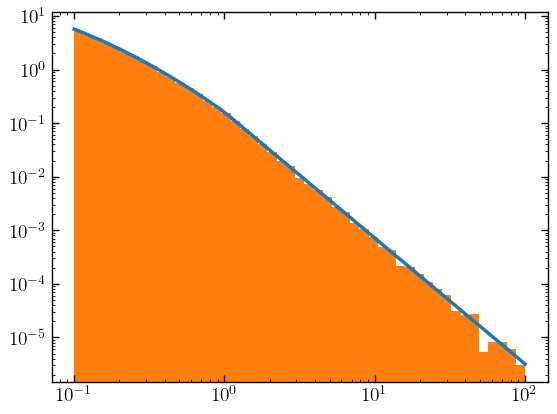

In [15]:
new_chabrier = NewChabrierIMF(normalisation="mass", normalisation_value=1000, Mmin=0.1)
M = np.geomspace(0.1, 100)
plt.loglog(M, new_chabrier(M) / new_chabrier.integrate(0.1, 100))
# plt.hist([new_chabrier.inverse_cdf(float(x), 0.1) for x in rng.uniform(0, 1, 10000)], density=True, bins=M)
plt.hist(new_chabrier.inverse_cdf(rng.uniform(0, 1, 100000), 0.1), density=True, bins=M)
plt.show()

## Lognormal
Used in Chabrier above

In [16]:
class NewLognormalIMF(pimf.LognormalIMF):
    def inverse_cdf(self, x, Mmin=None):
        if Mmin is None:
            Mmin = self.Mmin
        N = self.integrate(self.Mmin, self.Mmax)
        μ1 = np.log10(Mmin / self.mc) / (np.sqrt(2)*self.σ)
        return self.mc * 10 ** ( (np.sqrt(2)*self.σ) * special.erfinv(N*x/(self.ξ0 * self.lognormal_integral_constant) + special.erf(μ1) )  )

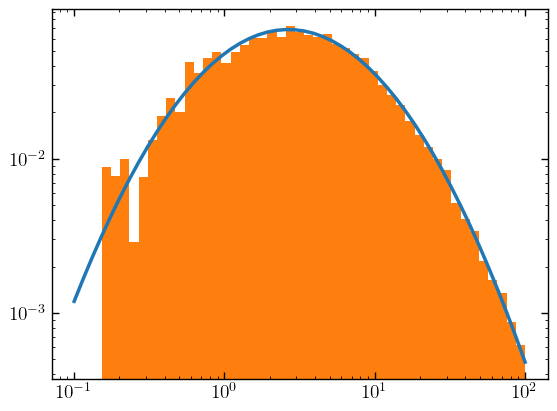

In [17]:
new_lognormal = NewLognormalIMF(10, sigma=0.5, normalisation="mass", normalisation_value=1000, Mmin=0.1)
M = np.geomspace(0.1, 100)
plt.loglog(M, new_lognormal(M) / new_lognormal.integrate(0.1, 100))
plt.hist([new_lognormal.inverse_cdf(float(x), 0.1) for x in rng.uniform(0, 1, 10000)], density=True, bins=M)
# plt.hist(new_chabrier.inverse_cdf(rng.uniform(0, 1, 100000), 0.01), density=True, bins=M)
plt.show()

# Sampling a given IMF
Now we have introduced everything we want to create something like `draw_samples()` that draws samples from an IMF until we're close enough to the mass of that imf.

We can either attach this to the IMF class, or not. I like it being attached I think but this would be messy.

https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5417S/abstract Introduces their method, where there is some offset from the target so if you go over with one realision, the next one you'll try to underestimate buy the same amount. Supposedly this is way better.

In [18]:
def draw_samples(imf, stop="below", max_iter=np.inf):
    if stop not in (stop_options:=["below", "above", "closest"]):
        raise ValueError(f"`{stop=}` is not a valid argument. Choose from {stop_options}.")
    Mtarget = imf.integrate_product(imf.Mmin, imf.Mmax)
    Mcurrent = 0
    masses = []
    while Mcurrent < Mtarget and len(masses) < max_iter:
        drawn_mass = imf.inverse_cdf(rng.uniform())

        hit_target = Mcurrent + drawn_mass > Mtarget

        if not hit_target:
            Mcurrent += drawn_mass
            masses.append(drawn_mass)
            continue

        if stop == "below":
            # Stop before the mass that pushes us over the target
            return masses
        elif stop == "above":
            # Stop after the mass that pushes us over the target
            masses.append(drawn_mass)
            return masses
        elif stop == "closest":
            # Draw the mass and add it to the list if it gets us closer to the target than leaving it off would
            if (Mcurrent + drawn_mass - Mtarget) < (Mtarget - Mcurrent):
            # if drawn_mass < 2 * (Mtarget - Mcurrent):
                Mcurrent += drawn_mass
                masses.append(drawn_mass)
                return masses
            else:
                return masses
    return masses

(array([1.229e+03, 1.151e+03, 1.136e+03, 1.067e+03, 1.021e+03, 1.000e+03,
        9.300e+02, 8.590e+02, 8.490e+02, 7.940e+02, 7.380e+02, 6.360e+02,
        5.260e+02, 4.970e+02, 3.990e+02, 3.510e+02, 3.180e+02, 2.700e+02,
        2.230e+02, 1.890e+02, 1.580e+02, 1.400e+02, 1.140e+02, 9.700e+01,
        7.200e+01, 6.900e+01, 6.200e+01, 4.200e+01, 3.700e+01, 3.300e+01,
        2.100e+01, 1.100e+01, 1.500e+01, 1.300e+01, 9.000e+00, 7.000e+00,
        8.000e+00, 8.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 7.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([-1.        , -0.93877551, -0.87755102, -0.81632653, -0.75510204,
        -0.69387755, -0.63265306, -0.57142857, -0.51020408, -0.44897959,
        -0.3877551 , -0.32653061, -0.26530612, -0.20408163, -0.14285714,
        -0.08163265, -0.02040816,  0.04081633,  0.10204082,  0.16326531,
         0.2244898 ,  0.28571429,  0.34693878,  0.40816327,  0.46938776,
         0.53061224,  

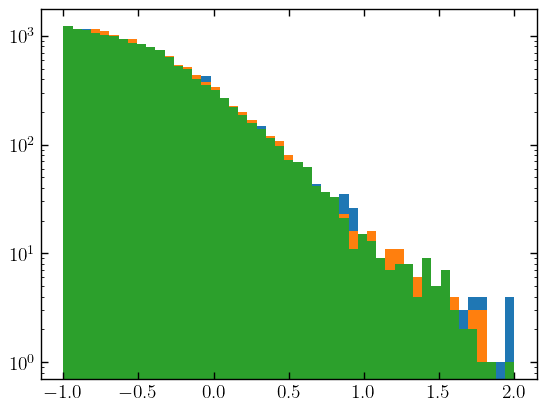

In [19]:
imf = NewChabrierIMF(normalisation="mass", normalisation_value=10000, Mmin=0.1, Mmax=100)
plt.hist(np.log10(draw_samples(imf)), bins=np.log10(np.geomspace(0.1, 100)), log=True)
plt.hist(np.log10(draw_samples(imf, stop="above", max_iter=100000)), bins=np.log10(np.geomspace(0.1, 100)), log=True)
plt.hist(np.log10(draw_samples(imf, stop="closest", max_iter=100000)), bins=np.log10(np.geomspace(0.1, 100)), log=True)

In [20]:
from spip.other_tools.examples import chabrier_IMF
from spip.sampling import generate_samples

stats 1.7478713989257812 s
sampling 0.00498199462890625 s
physics 0.38710665702819824 s
ssp 0.004175901412963867 s
write 0.00356292724609375 s


In [21]:
%timeit generate_samples(IMF=chabrier_IMF, Mtot=1e4, N=100, sampling_method="bf", stop_method="before")

27.6 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
imf = NewChabrierIMF(normalisation="mass", normalisation_value=1e4)
%timeit [draw_samples(imf, stop="below") for _ in range(100)]

14.8 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Can see this is faster (only for sampling though) than spip by ~2x. 